In [7]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import IterativeModelWithFirst, IterativeModelWithFirst_Con
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random

In [8]:
!nvidia-smi

Wed Mar 20 14:11:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:37:00.0 Off |                    0 |
| N/A   74C    P0            169W /  250W |   33188MiB /  40960MiB |     96%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
# data_set = BallDataset()
# data_set = BallDataset(output_first=True)
# data_set = BallDataset(is_previous=False)
# data_set = BallDataset("ellipse/uniform_samples_80.json")
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
# data_set = DAVIS_Seq2(is_one_video=True)
test_set = Balltest("ellipse/uniform_samples_80.json")
# test_set = Balltest()

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([18]), tensor([19]))

Text(0.5, 1.0, 'First Frame in test set')

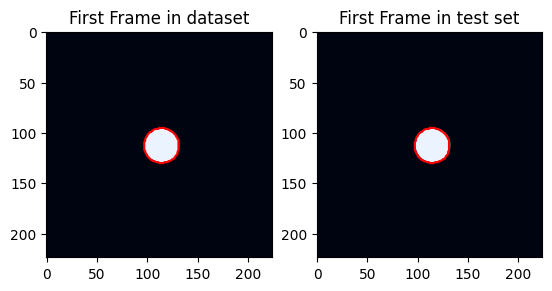

In [11]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

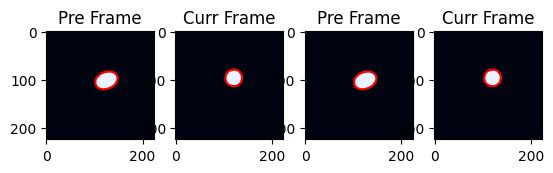

In [12]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')

In [13]:
model = IterativeModelWithFirst()

/work3/s232248/miniconda3/envs/vars/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
model = model.cuda()

results = model(
    first_frame.cuda(), 
    first_boundary.cuda(), 
    pre_frame.cuda(), 
    curr_frame.cuda(), 
    pre_boundary.cuda(), 
)

In [15]:
order_loss(results[0], curr_boundary.cuda())

tensor(9.5934, device='cuda:0', grad_fn=<DivBackward0>)

In [16]:
# model = IterativeModelWithFirst().to('cuda')
model = IterativeModelWithFirst().to('cuda')
model_name = "uniform_model"
# data_set = BallDataset(output_first=True)
# data_set = BallDataset(is_previous=False)
# data_set = BallDataset("ellipse/uniform_samples_80.json")
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
# data_set = BallDataset("ellipse/uniform_samples_80.json", is_previous=False)
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [17]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

0.17142581939697266

In [18]:
dict_loss = {}
num_epochs = 500
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
min_loss = 1e10
possibility = 0
pred_dict: dict[int, torch.Tensor] = {}
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
def lr_lambda(epoch):
    if epoch < 5:
        return 1
    elif epoch < 40:
        return 0.1
    else:
        return 0.01
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
for e in range(num_epochs):
    model.train()
    mean_loss = 0
    # for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in tqdm(data_loader, position=0, leave=True):
    for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
        first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary = (
            first_frame.to("cuda"),
            first_boundary.to("cuda"),
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        pre_idx = pre_idx.item()
        curr_idx = curr_idx.item()
        if random.uniform(0, 100) < possibility:
            pre_boundary = pred_dict[pre_idx].to("cuda").detach()
        optimizer.zero_grad()
        results = model(first_frame, first_boundary, pre_frame, curr_frame, pre_boundary)
        pred_dict[curr_idx] = results[-1].int().clamp(0, 223)
        refine_num = len(results)
        loss = 0
        for i in range(refine_num):
            loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
        mean_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
    mean_loss /= len(data_loader)
    # tqdm.write(f"Epoch {e + 1}, Loss: {mean_loss}, Poss: {possibility}", end="")
    print(f"Epoch {e + 1}, Loss: {mean_loss:.2f}")
    dict_loss[e] = mean_loss
    if possibility < 0:
        possibility += 95
    # scheduler.step()

Epoch 1, Loss: 44.40
Epoch 2, Loss: 36.85
Epoch 3, Loss: 37.06
Epoch 4, Loss: 38.52
Epoch 5, Loss: 36.12
Epoch 6, Loss: 35.96
Epoch 7, Loss: 37.24
Epoch 8, Loss: 36.79
Epoch 9, Loss: 35.48
Epoch 10, Loss: 35.20
Epoch 11, Loss: 33.09
Epoch 12, Loss: 33.51
Epoch 13, Loss: 30.27
Epoch 14, Loss: 27.12
Epoch 15, Loss: 26.31
Epoch 16, Loss: 22.54
Epoch 17, Loss: 21.06
Epoch 18, Loss: 21.58
Epoch 19, Loss: 18.26
Epoch 20, Loss: 20.07
Epoch 21, Loss: 17.23
Epoch 22, Loss: 19.93
Epoch 23, Loss: 16.25


KeyboardInterrupt: 

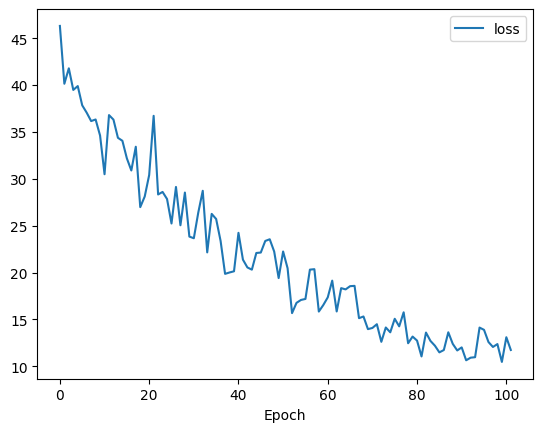

In [29]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()), label="loss")
# plt.plot(list(poss_dict.keys()), list(poss_dict.values()), label="possibility")
plt.xlabel("Epoch")
# plt.ylabel("Loss")
plt.legend()

  0%|                                                                                                                                                      | 0/19 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.64it/s]


0.42476040441196244

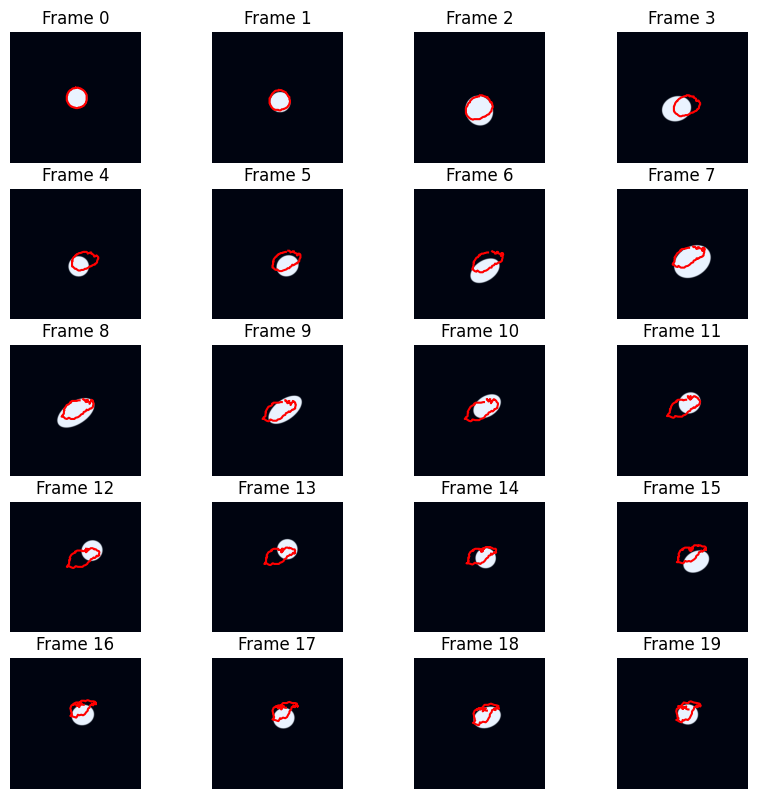

In [30]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    first_img, first_sgm, first_boundary = test_dataset[0]
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 4, 1)
    plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    plt.axis('off')
    plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        with torch.no_grad():
            results = model(
                first_img.unsqueeze(0).to(device),
                first_boundary.unsqueeze(0).to(device),
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            pre_boundary = results[-1].squeeze(0).long()
            pre_img = img
            if i % interval == 0:
                plt.subplot(10, 4, i // interval + 1)
                # plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
# test_dataset = Balltest()
test_dataset = Balltest("ellipse/uniform_samples_80.json")

test_model_one_video(model, test_dataset,)